In [1]:
!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2023-06-13 04:37:53--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rbajpdlh7efkdo1/male_female_face_images.zip [following]
--2023-06-13 04:37:54--  https://www.dropbox.com/s/raw/rbajpdlh7efkdo1/male_female_face_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8b00b64b9f5b731b80da6c82ac.dl.dropboxusercontent.com/cd/0/inline/B9573kGb-MzHobsT_wM1bUhtPEdTSAaSB68EjMts_AXlqFBHcY2RLggi9kEPezlfz7Tjq9aZvw1pj3H_VXaOrJoAOQHtJtAg__6ug7Xhry7C6NBM9uK62_q1v0aQcvyUBTTbbOTjYZqXy1YDe9C3qGQJXHZvCTxWsJqPm3iEyhP2vg/file# [following]
--2023-06-13 04:37:55--  https://uc8b00b64b9f5b731b80da6c82ac.dl.dropboxusercontent.com/cd/0/inline/B9573kGb-MzHobsT_wM1bUhtPEdTSAaSB6

In [2]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.8 MB/s eta 0:00

Ensure that we crop the images so that we retain only the faces and discard additional details in the image. First, we will download the cascade filter (more on cascade filters in OpenCV , Using OpenCV Utilities for Image Analysis), which will help in identifying faces within an image:

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
!mkdir cropped_faces
images = Glob('/content/females/*.jpg')+Glob('/content/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

# Specify the transformation to perform on each image:

In [5]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [7]:
ds = Faces(folder='cropped_faces/')

In [8]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Define weight initialization so that the weights have a smaller spread:

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

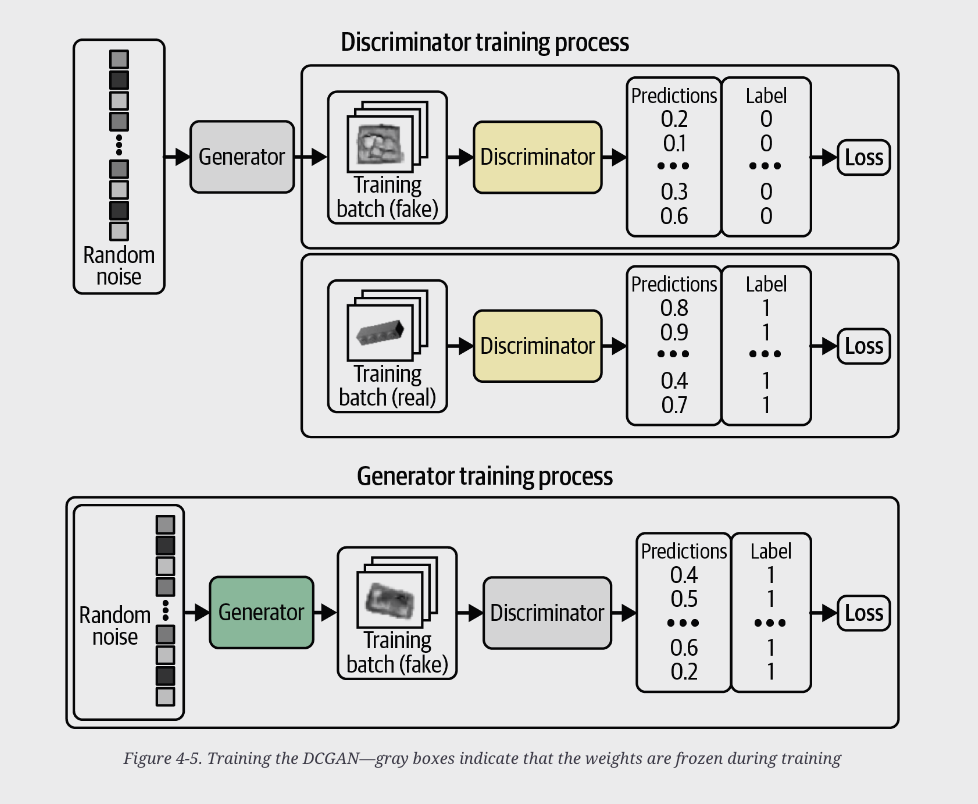

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [11]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11         

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)


In [13]:

generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [14]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [15]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCH: 1.000  d_loss: 0.644  g_loss: 8.417  (44.20s - 1060.69s remaining)
EPOCH: 2.000  d_loss: 0.615  g_loss: 5.758  (83.81s - 963.77s remaining)
EPOCH: 3.000  d_loss: 0.583  g_loss: 4.562  (124.02s - 909.47s remaining)
EPOCH: 4.000  d_loss: 0.600  g_loss: 3.877  (164.67s - 864.53s remaining)
EPOCH: 5.000  d_loss: 0.592  g_loss: 3.503  (204.20s - 816.81s remaining)
EPOCH: 6.000  d_loss: 0.617  g_loss: 3.319  (244.38s - 773.86s remaining)
EPOCH: 7.000  d_loss: 0.635  g_loss: 3.180  (285.19s - 733.34s remaining)
EPOCH: 8.000  d_loss: 0.640  g_loss: 3.050  (326.37s - 693.55s remaining)
EPOCH: 9.000  d_loss: 0.652  g_loss: 3.000  (367.66s - 653.63s remaining)
EPOCH: 10.000  d_loss: 0.603  g_loss: 2.940  (408.93s - 613.40s remaining)
EPOCH: 11.000  d_loss: 0.626  g_loss: 2.951  (450.39s - 573.23s remaining)
EPOCH: 12.000  d_loss: 0.597  g_loss: 2.942  (492.06s - 533.06s remaining)
EPOCH: 13.000  d_loss: 0.567  g_loss: 2.983  (532.00s - 491.07s remaining)
EPOCH: 14.000  d_loss: 0.559  g_los

100%|██████████| 126/126 [00:00<00:00, 274.56it/s]


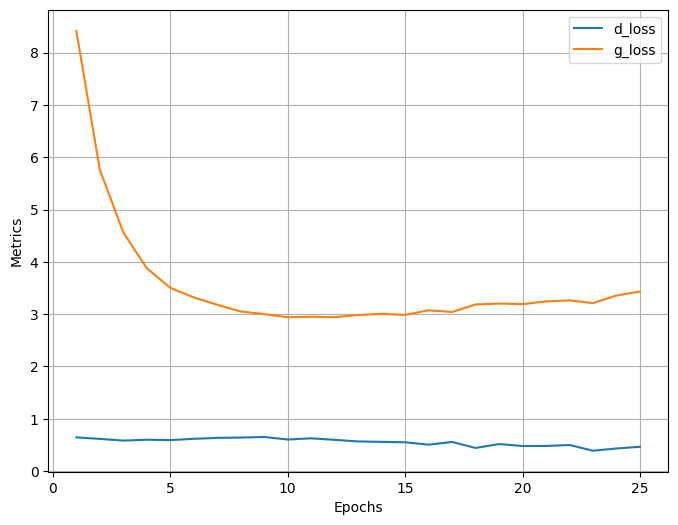

In [16]:
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

The discriminator and generator are constantly fighting for dominance, which can make the DCGAN training process unstable. Ideally, the training process will find an equilibrium that allows the generator to learn meaningful information from the discriminator and the quality of the images will start to improve. After enough epochs, the discriminator tends to end up dominating

It is somewhat miraculous that a neural network is able to convert random noise into something meaningful. It is worth remembering that we haven’t provided the model with any additional features beyond the raw pixels, so it has to work out high-level concepts such as how to draw shadows, cuboids, and circles entirely by itself.

Another requirement of a successful generative model is that it doesn’t only reproduce images from the training set. To test this, we can find the image from the training set that is closest to a particular generated example.

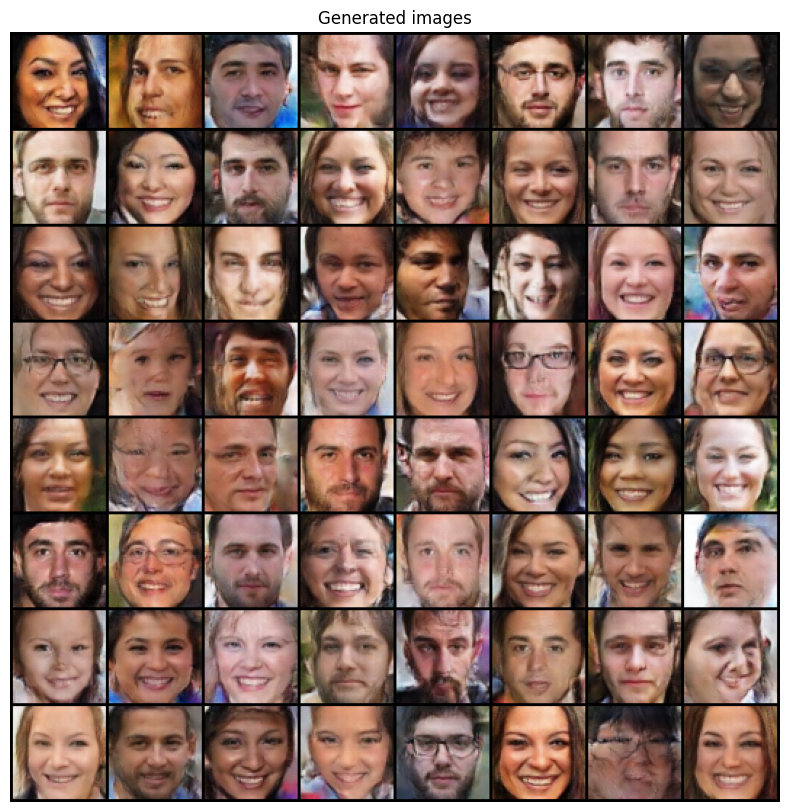

In [17]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')

1. GAN Training: Tips and Tricks
While GANs are a major breakthrough for generative modeling, they are also notoriously difficult to train. We will explore some of the most common problems and challenges encountered when training GANs in this section, alongside potential solutions. In the next section, we will look at some more fundamental adjustments to the GAN framework that we can make to remedy many of these problems.

2. Discriminator overpowers the generator
If the discriminator becomes too strong, the signal from the loss function becomes too weak to drive any meaningful improvements in the generator. In the worst-case scenario, the discriminator perfectly learns to separate real images from fake images and the gradients vanish completely, leading to no training whatsoever.


2a. Example output when the discriminator overpowers the generator
If you find your discriminator loss function collapsing, you need to find ways to weaken the discriminator. Try the following suggestions:

- Increase the rate parameter of the Dropout layers in the discriminator to dampen the amount of information that flows through the network.

- Reduce the learning rate of the discriminator.

- Reduce the number of convolutional filters in the discriminator.

A- dd noise to the labels when training the discriminator.

- Flip the labels of some images at random when training the discriminator.

- Generator overpowers the discriminator
If the discriminator is not powerful enough, the generator will find ways to easily trick the discriminator with a small sample of nearly identical images. This is known as mode collapse.

- For example, suppose we were to train the generator over several batches without updating the discriminator in between. The generator would be inclined to find a single observation (also known as a mode) that always fools the discriminator and would start to map every point in the latent input space to this image. Moreover, the gradients of the loss function would collapse to near 0, so it wouldn’t be able to recover from this state.

- Even if we then tried to retrain the discriminator to stop it being fooled by this one point, the generator would simply find another mode that fools the discriminator, since it has already become numb to its input and therefore has no incentive to diversify its output.

Example of mode collapse when the generator overpowers the discriminator
If you find that your generator is suffering from mode collapse, you can try strengthening the discriminator using the opposite suggestions to those listed in the previous section. Also, you can try reducing the learning rate of both networks and increasing the batch size.

- Uninformative loss
Since the deep learning model is compiled to minimize the loss function, it would be natural to think that the smaller the loss function of the generator, the better the quality of the images produced. However, since the generator is only graded against the current discriminator and the discriminator is constantly improving, we cannot compare the loss function evaluated at different points in the training process. The loss function of the generator actually increases over time, even though the quality of the images is clearly improving. This lack of correlation between the generator loss and image quality sometimes makes GAN training difficult to monitor.

- Hyperparameters
As we have seen, even with simple GANs, there are a large number of hyperparameters to tune. As well as the overall architecture of both the discriminator and the generator, there are the parameters that govern batch normalization, dropout, learning rate, activation layers, convolutional filters, kernel size, striding, batch size, and latent space size to consider. GANs are highly sensitive to very slight changes in all of these parameters, and finding a set of parameters that works is often a case of educated trial and error, rather than following an established set of guidelines.

This is why it is important to understand the inner workings of the GAN and know how to interpret the loss function—so that you can identify sensible adjustments to the hyperparameters that might improve the stability of the model.

- Tackling GAN challenges
In recent years, several key advancements have drastically improved the overall stability of GAN models and diminished the likelihood of some of the problems listed earlier, such as mode collapse.

In the remainder of this chapter we shall examine the Wasserstein GAN with Gradient Penalty (WGAN-GP), which makes several key adjustments to the GAN framework we have explored thus far to improve the stability and quality of the image generation process.